# Amadeus Data Challenge

## Lorenzo von Ritter

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
time searches = pd.read_csv("../Files/searches.csv", sep="^", usecols=['Date','Time','TxnCode','OfficeID','Country','Origin','Destination','RoundTrip'], parse_dates=[['Date','Time']], dtype={'TxnCode': object, 'OfficeID': object, 'Country': object, 'Origin': object,'Destination': object, 'RoundTrip': np.float64})

CPU times: user 2min 13s, sys: 8.06 s, total: 2min 21s
Wall time: 3min 24s


##### before importing bookings, remove whitespaces before the delimiter from the original file with $sed 's/\s*^/^/g' bookings.csv > bookingsClean.csv

In [5]:
time bookings = pd.read_csv("../Files/bookingsClean.csv", sep="^", usecols=['act_date','source','dep_port','dep_city','arr_port','arr_city','pax', 'off_time'], parse_dates=['act_date','off_time'], dtype={'dep_port': object, 'arr_port': object, 'arr_city': object, 'pax': np.float64})

CPU times: user 4min 38s, sys: 11.6 s, total: 4min 50s
Wall time: 5min 38s


###Exercise 1: Count the number of lines

##### compare shape and count()

In [6]:
time searches.shape[0]

CPU times: user 13 µs, sys: 0 ns, total: 13 µs
Wall time: 14.1 µs


20390198

In [7]:
time searches.count()

CPU times: user 6.16 s, sys: 341 ms, total: 6.5 s
Wall time: 8.42 s


Date_Time      20390198
TxnCode        20390165
OfficeID       20390165
Country        20387721
Origin         20390165
Destination    20390165
RoundTrip      20390164
dtype: int64

##### shape is quicker than count(), but count will exclude NaN values. However, we only want to know the number of rows

In [8]:
searchesSize = searches.shape[0]
searchesSize

20390198

In [9]:
bookingsSize = bookings.shape[0]
bookingsSize

10000010

### Execise 2: Top 10 airports

In [10]:
airports = bookings.groupby('arr_port').pax.count()
airports.sort(ascending=0)

In [11]:
airports[0:10]

arr_port
LHR         215551
JFK         158930
CDG         149390
LAX         143220
DXB         135640
BKK         130420
MIA         117820
SFO         110970
MNL         109530
ORD          99750
dtype: int64

### Exercise 3: Monthly arrivals in Málaga, Madrid and Barcelona

In [12]:
searches.dtypes

Date_Time       object
TxnCode         object
OfficeID        object
Country         object
Origin          object
Destination     object
RoundTrip      float64
dtype: object

##### make date column of type datetime

In [13]:
searches.Date_Time = pd.to_datetime(searches.Date_Time)

In [14]:
searches.dtypes

Date_Time       object
TxnCode         object
OfficeID        object
Country         object
Origin          object
Destination     object
RoundTrip      float64
dtype: object

##### did not work

In [15]:
special_searches = searches[(searches["Destination"] == "AGP") | (searches["Destination"] == "BCN") | (searches["Destination"] == "MAD")]

In [16]:
datecount = special_searches.groupby(['Date_Time','Destination']).Date_Time.count()
datecount = datecount.unstack('Destination')
datecount.index.dtype

dtype('O')

In [17]:
datecount.index = pd.to_datetime(datecount.index)
datecount.index.dtype

dtype('<M8[ns]')

##### now it worked

In [18]:
monthcount = datecount.resample('M', how=sum)
monthcount

Destination,AGP,BCN,MAD
2013-01-31,9633,29469,24258
2013-02-28,8379,28329,22800
2013-03-31,10659,30552,24681
2013-04-30,8265,31236,25251
2013-05-31,10830,28728,26334
2013-06-30,7923,26505,22800
2013-07-31,8892,29241,22971
2013-08-31,7866,27075,21831
2013-09-30,8151,23427,21147
2013-10-31,6499,20276,22294


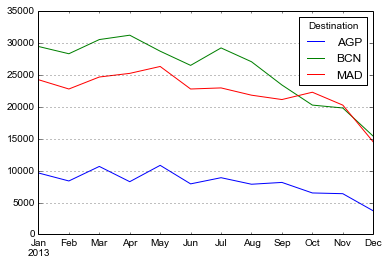

In [19]:
monthcount.plot()

### Exercise 4: Join DataFrames

##### only take bookings, no cancellations

In [20]:
positiveBookings = bookings[bookings['pax']>0]

In [49]:
bookedSearches = pd.merge(searches.head(100000), positiveBookings.head(100000), left_on=['Origin','Destination'], right_on=['dep_port','arr_port'], left_index=True)

In [55]:
bookedSearches['index'] = bookedSearches.index
bookedSearches.drop_duplicates(cols='index',inplace=True)

In [56]:
bookedSearches[['Date_Time','TxnCode','OfficeID','Country','Origin','Destination','RoundTrip','pax']].sort()

,Date_Time,TxnCode,OfficeID,Country,Origin,Destination,RoundTrip,pax
5,2013-02-02 19:43:12,FQD,e8741eaf2fa2f71f931475d18fa72096,US,DEN,LGA,0,1
6,2013-02-02 19:43:12,FQD,e8741eaf2fa2f71f931475d18fa72096,US,DEN,LGA,0,1
7,2013-02-04 22:36:52,FFP,7d668b5f750866f7a8f10f1505c9423f,JP,NRT,SIN,0,2
8,2013-02-04 22:36:52,FFP,7d668b5f750866f7a8f10f1505c9423f,JP,NRT,SIN,0,2
9,2013-02-04 22:36:52,FFP,7d668b5f750866f7a8f10f1505c9423f,JP,NRT,SIN,0,2
10,2013-02-04 22:36:52,FFP,7d668b5f750866f7a8f10f1505c9423f,JP,NRT,SIN,0,2
15,2013-02-04 22:36:52,FFP,7d668b5f750866f7a8f10f1505c9423f,JP,NRT,SIN,0,1
16,2013-02-04 22:36:52,FFP,7d668b5f750866f7a8f10f1505c9423f,JP,NRT,SIN,0,1
17,2013-02-04 22:36:52,FFP,7d668b5f750866f7a8f10f1505c9423f,JP,NRT,SIN,0,1
18,2013-02-04 22:36:52,FFP,7d668b5f750866f7a8f10f1505c9423f,JP,NRT,SIN,0,1


In [ ]:
#searches['booked'] = pd.Series(np.zeros((searchesSize,), dtype=numpy.int), index=searches.index)

In [ ]:
searches['booked'] = pd.Series(searches['TxnCode'] == bookedSearches['TxnCode'].any), index=searches.index)

In [ ]:
searches.to_csv('searcheswithbookings.csv', sep='^')